# Cleaning regression with different AEs

This notebook explores AEs with ranging complexity and looks which one performs the best.

In [1]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import jaccard_score

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [4]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)


In [5]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

#data_true_binary = np.zeros((64*chunk_tot, 56, 56))
#data_true_binary[data_true>threshold] = 1
#data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))
data_true_nonan_flat = data_true_nonan.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
pix_max_noisy = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
pix_min_noisy = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num((data_noisy_arr - pix_min_noisy)/(pix_max_noisy-pix_min_noisy))
data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())

# Now normalize the true data in the same way as the noisy data

data_true_arr = data_true_nonan_flat[images_high_mask]
pix_max_true = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis]
pix_min_true = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis]
data_true_norm = np.nan_to_num((data_true_arr - pix_min_true)/(pix_max_true-pix_min_true))
data_true_tensor = (torch.from_numpy(data_true_norm).float())

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]


In [6]:
# Now with a minimum of 0

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0


data_true_nonan_flat = data_true_nonan.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
data_noisy_arr[np.nan_to_num(data_noisy_arr)<0] = 0


pix_max_noisy = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num(data_noisy_arr/pix_max_noisy)
data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())


# Now normalize the true data in the same way as the noisy data

data_true_arr = data_true_nonan_flat[images_high_mask]
pix_max_true = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis]
data_true_norm = np.nan_to_num(data_true_arr/pix_max_true)
data_true_tensor = (torch.from_numpy(data_true_norm).float())

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()

data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]


**Models**

In [8]:
# AE with only 1 layer

class AE1(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder functions
        self.conv1 = nn.Conv2d(1, 100, kernel_size=(3,3))
        
        # Decoder functions
        self.deconv1 = nn.ConvTranspose2d(100, 1, kernel_size=(3,3))
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)  
            
        N = (x.shape)[0]
        
        # Encoder part
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = self.deconv1(x)
        x = F.relu(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x                 

In [9]:
# AE with 2 layers

class AE2(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 100
            
        # Encoder functions
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv2 = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1 = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2 = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(x, (2,2)))

        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = self.deconv1(x)
        x = F.relu(x)
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = self.deconv2(x)
        
        # Get the right shape
        x = x.squeeze(0)
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

In [10]:
# AE with 3 layers

class AE3(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 100
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 20, kernel_size=(3,3), padding='same')
        self.conv2 = nn.Conv2d(20, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1 = nn.ConvTranspose2d(second_layer, 20, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(20, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

In [11]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

In [12]:
# AE with 5 layers

class AE5(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 100
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 25, kernel_size=(3,3), padding='same')
        self.conv1c = nn.Conv2d(25, 50, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(50, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 50, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(50, 25, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(25, 10, kernel_size=(3,3), padding=1)
        self.deconv2c = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        x = self.conv1c(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = F.relu(self.deconv2b(x))
        x = self.deconv2c(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

In [13]:
# AE with 6 layers

class AE6(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 100
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 25, kernel_size=(3,3), padding='same')
        self.conv1c = nn.Conv2d(25, 50, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(50, 100, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(100, 150, kernel_size=(3,3), padding='same')
        self.conv2c = nn.Conv2d(150, 250, kernel_size=(3,3), padding='same')
        
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(250, 150, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(150, 100, kernel_size=(3,3), padding=1)
        self.deconv1c = nn.ConvTranspose2d(100, 50, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(50, 25, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(25, 10, kernel_size=(3,3), padding=1)
        self.deconv2c = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        x = self.conv1c(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        x = self.conv2c(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.relu(self.deconv1c(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = F.relu(self.deconv2b(x))
        x = self.deconv2c(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

In [14]:
print("Number of parameters AE1:")
print(sum(p.numel() for p in AE1().parameters() if p.requires_grad))
print()

print("Number of parameters AE2:")
print(sum(p.numel() for p in AE2().parameters() if p.requires_grad))
print()

print("Number of parameters AE3:")
print(sum(p.numel() for p in AE3().parameters() if p.requires_grad))
print()

print("Number of parameters AE4:")
print(sum(p.numel() for p in AE4().parameters() if p.requires_grad))

print("Number of parameters AE5:")
print(sum(p.numel() for p in AE5().parameters() if p.requires_grad))

print("Number of parameters AE6:")
print(sum(p.numel() for p in AE6().parameters() if p.requires_grad))

Number of parameters AE1:
1901

Number of parameters AE2:
18301

Number of parameters AE3:
39941

Number of parameters AE4:
116996
Number of parameters AE5:
297651
Number of parameters AE6:
1063101


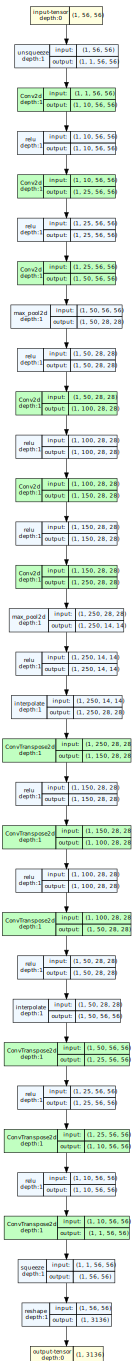

In [15]:
# Visualize the model
model_graph = draw_graph(AE6(), input_size=(1,56,56), expand_nested=True)
model_graph.visual_graph

**Fitting functions**

In [16]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

batch_size=1
weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.mse_loss(output, true)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.mse_loss(output, true)
            test_loss += loss.item()
    
    test_loss /= len(data_noisy_test)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.6f}'.format(test_loss))

In [17]:
n_epochs = 40
test_losses_all = []

**1 layer**

In [18]:
%%time

learning_rate = 0.0001

network = AE1()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*100 for i in range(n_epochs + 1)]


test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)


Test set: Avg. loss: 0.001477
Training set: Avg. loss: 0.0008

Test set: Avg. loss: 0.000447
Training set: Avg. loss: 0.0004

Test set: Avg. loss: 0.000365
Training set: Avg. loss: 0.0004

Test set: Avg. loss: 0.000333
Training set: Avg. loss: 0.0004

Test set: Avg. loss: 0.000319
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000297
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000282
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000280
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000264
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000259
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000253
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000261
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000252
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000241
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000247
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000236
Training set: Avg. loss:

tensor(-7.4585)
tensor(-7.2172)
tensor(-7.8728)


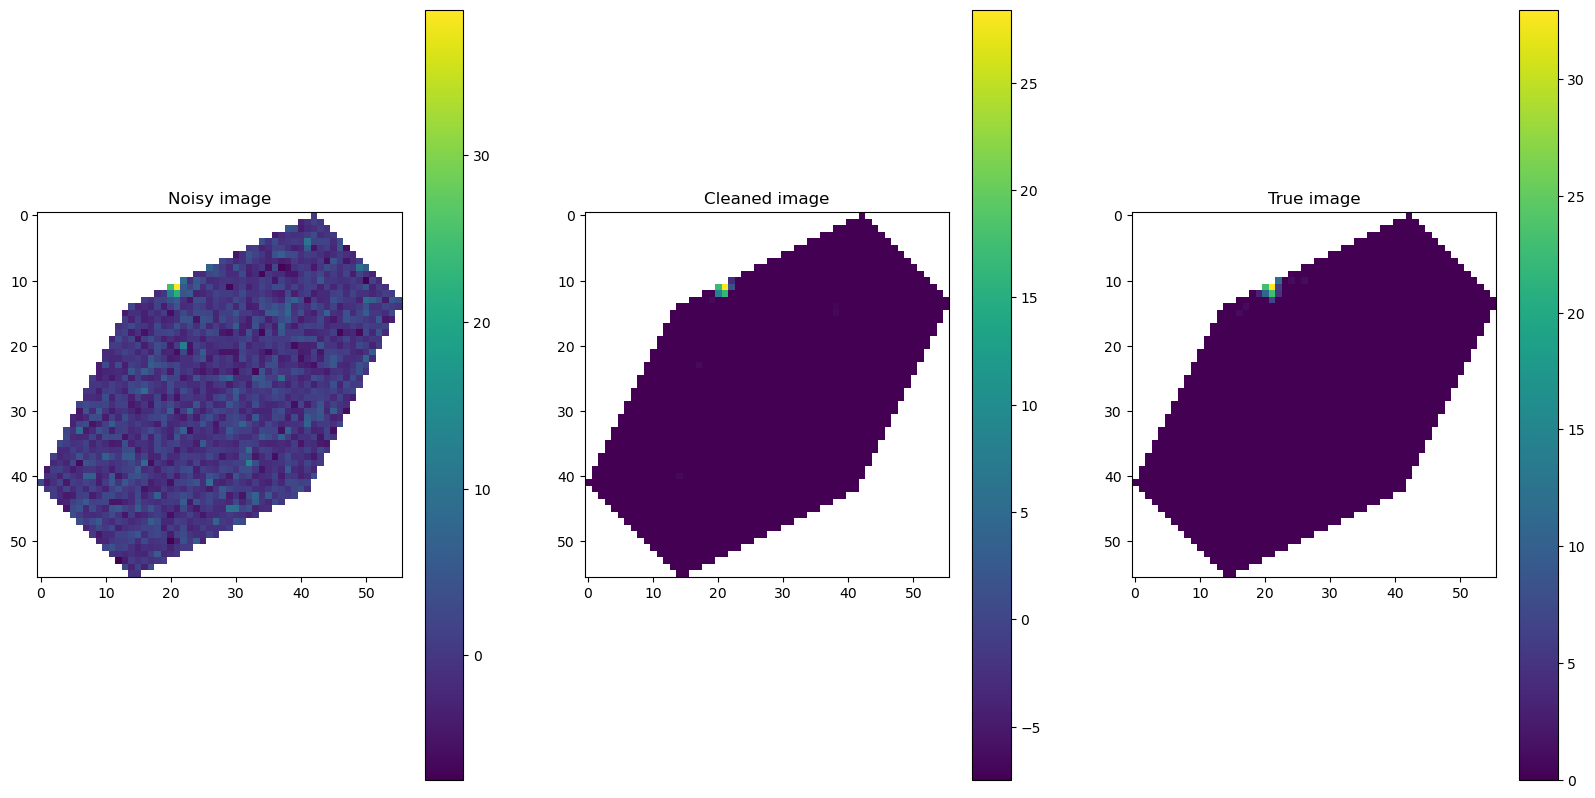

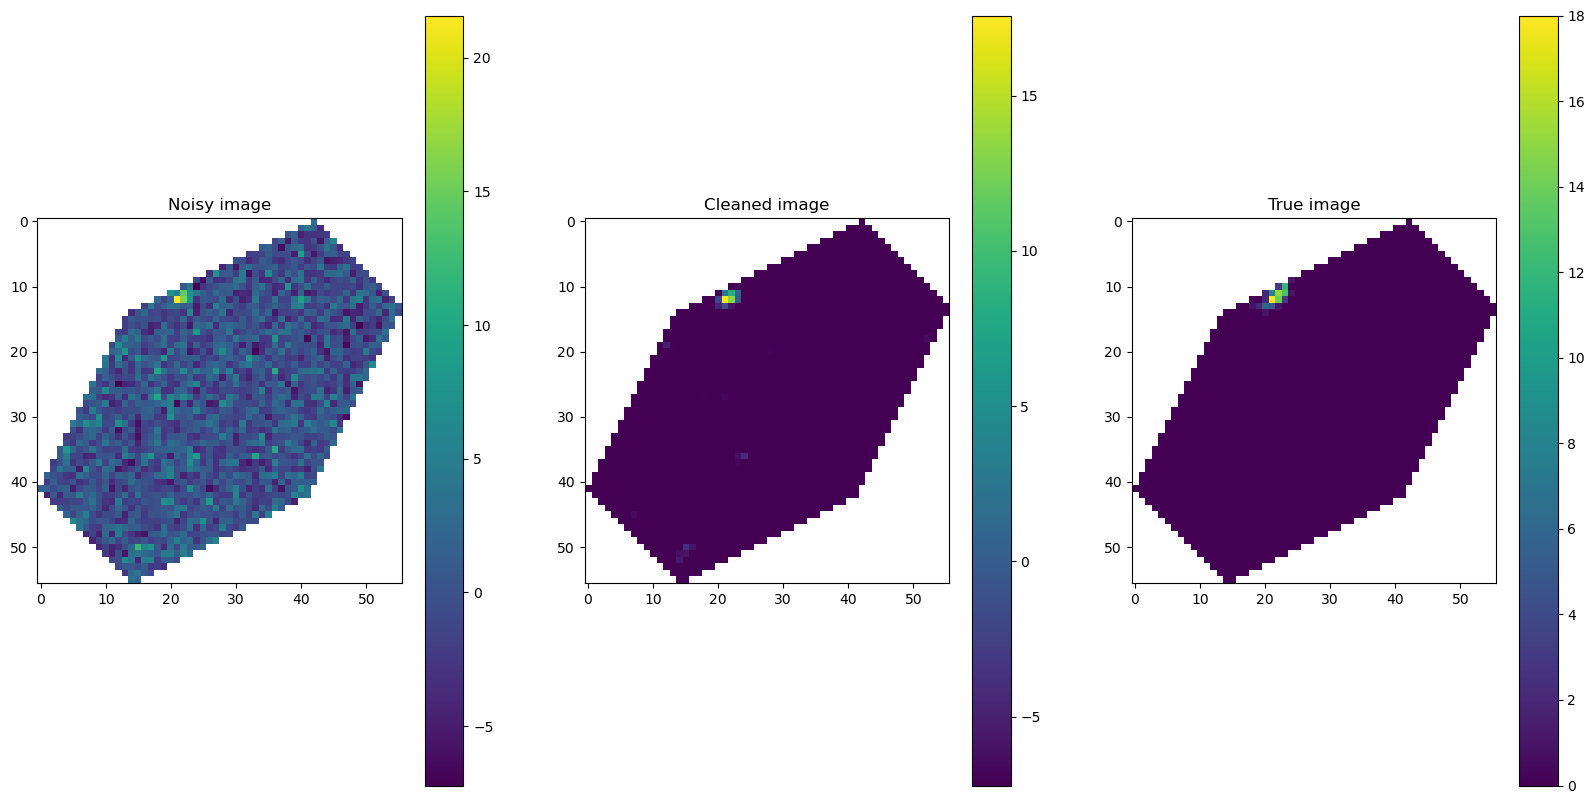

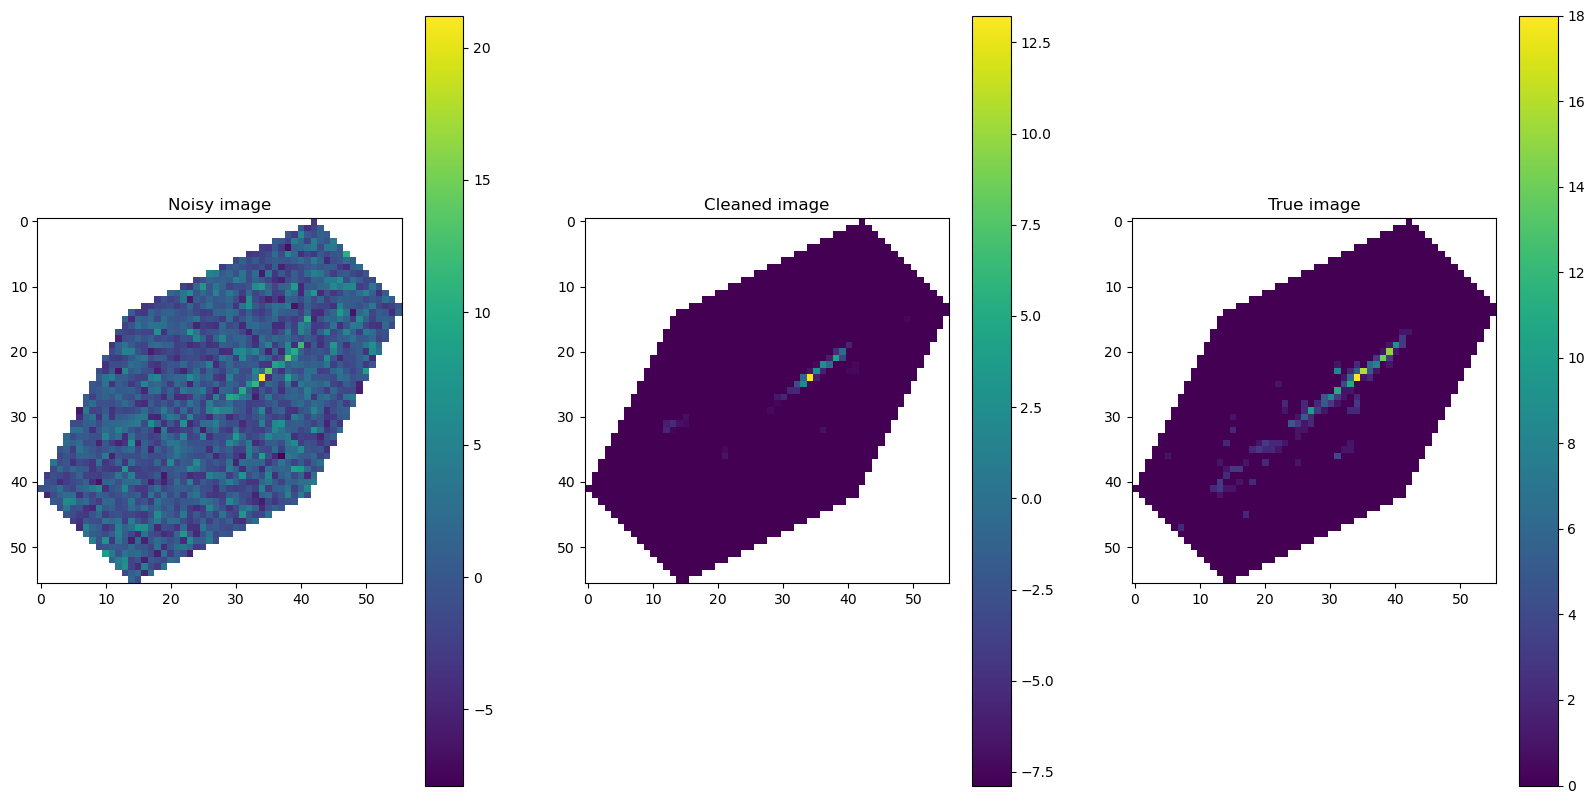

In [19]:
n_start = 3
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))


    im_clean = (output.data).reshape(56, 56)
    
    im_clean = im_clean*(pix_max_noisy[idx_split+im_i][0][0]-pix_min_noisy[idx_split+im_i][0][0]) + pix_min_noisy[idx_split+im_i][0][0]
    print(im_clean.min())
    #im_clean = im_clean_prob.round()
    #mask_clean = im_clean.astype(bool)
    #im_clean_good = np.zeros((56,56))

    #im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,3,figsize=(20,10))

    fig_noisy = axs[0].imshow(data_noisy_test_im[im_i])#, vmin=0)
    axs[0].set_title("Noisy image")
    fig.colorbar(fig_noisy, ax=axs[0])

    fig_clean = axs[1].imshow(im_clean.detach().numpy())#, vmin=0)
    axs[1].set_title("Cleaned image")
    fig.colorbar(fig_clean, ax=axs[1])

    fig_true = axs[2].imshow(data_true_test_im[im_i])#, vmin=0)
    axs[2].set_title("True image")
    fig.colorbar(fig_true, ax=axs[2])

plt.show()    

**2 layers**

In [20]:
%%time

learning_rate = 0.0001

network = AE2()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*100 for i in range(n_epochs + 1)]


test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)


Test set: Avg. loss: 0.030751
Training set: Avg. loss: 0.0006

Test set: Avg. loss: 0.000379
Training set: Avg. loss: 0.0004

Test set: Avg. loss: 0.000329
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000308
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000292
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000285
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000277
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000272
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000268
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000285
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000259
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000261
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000256
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000253
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000251
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000251
Training set: Avg. loss:

tensor(-11.1159)
tensor(-8.6167)
tensor(-9.8731)


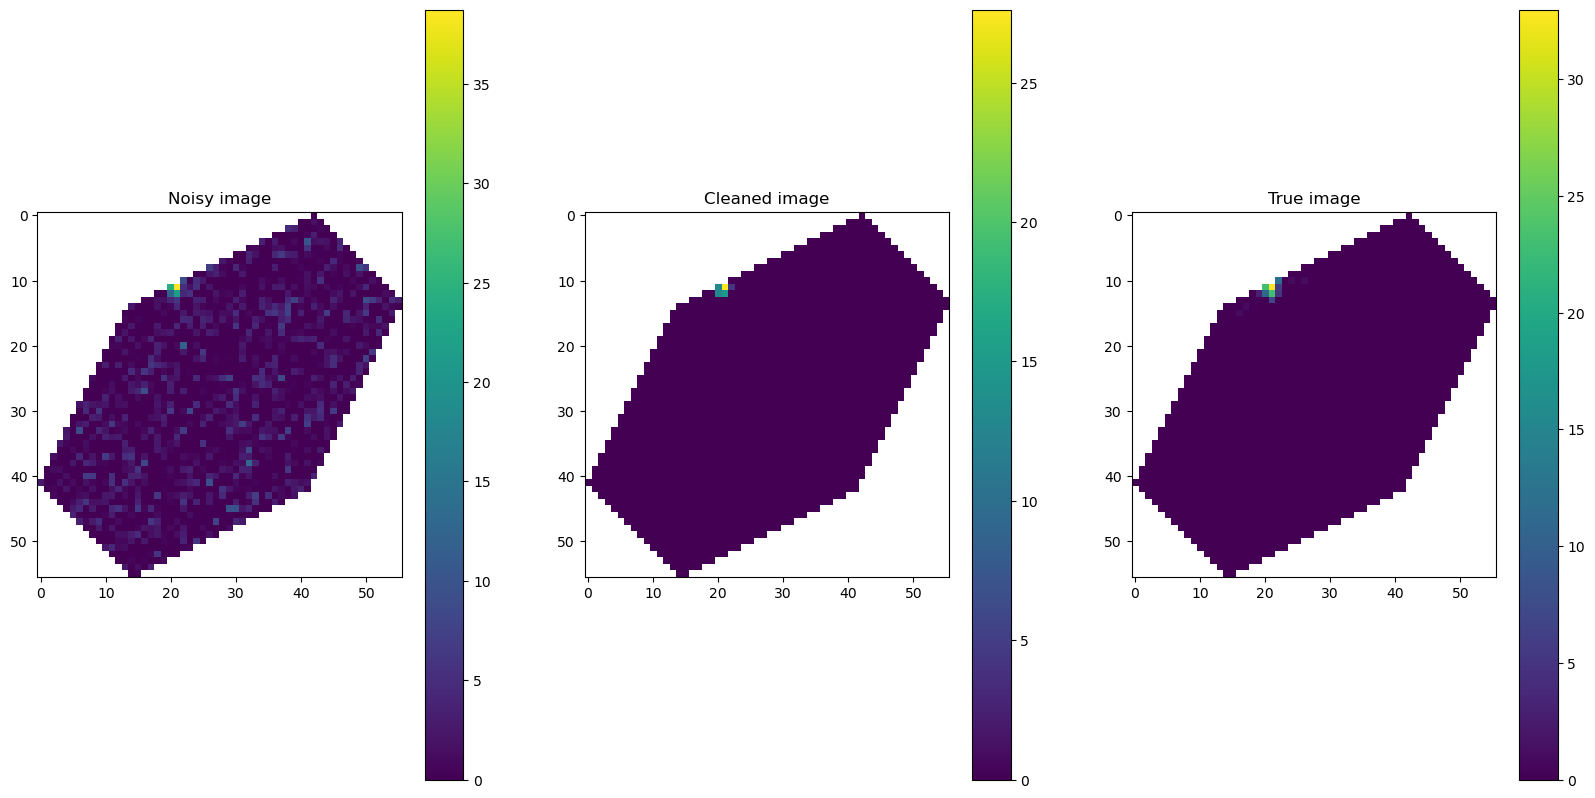

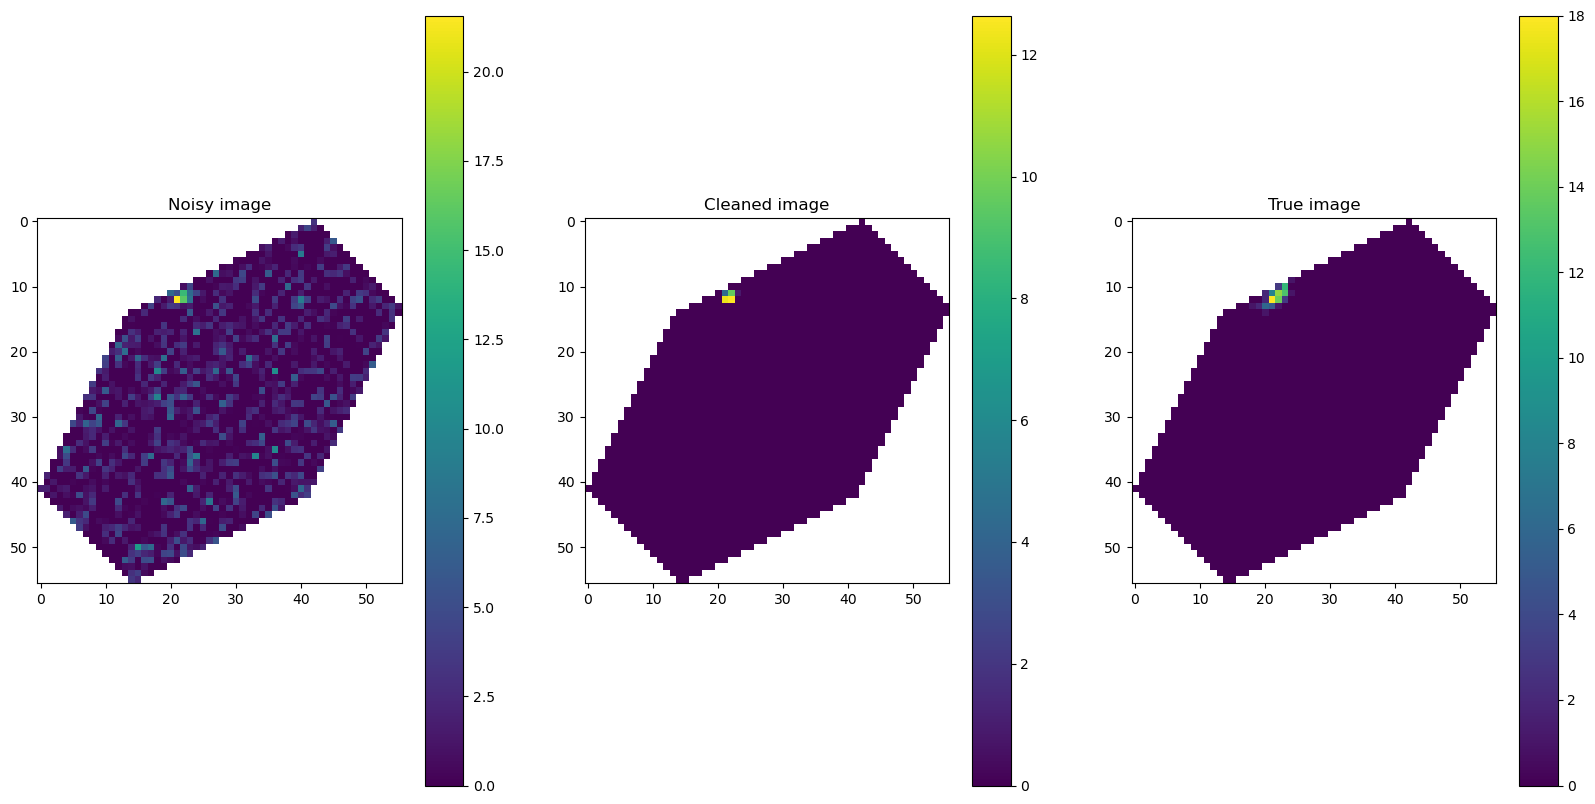

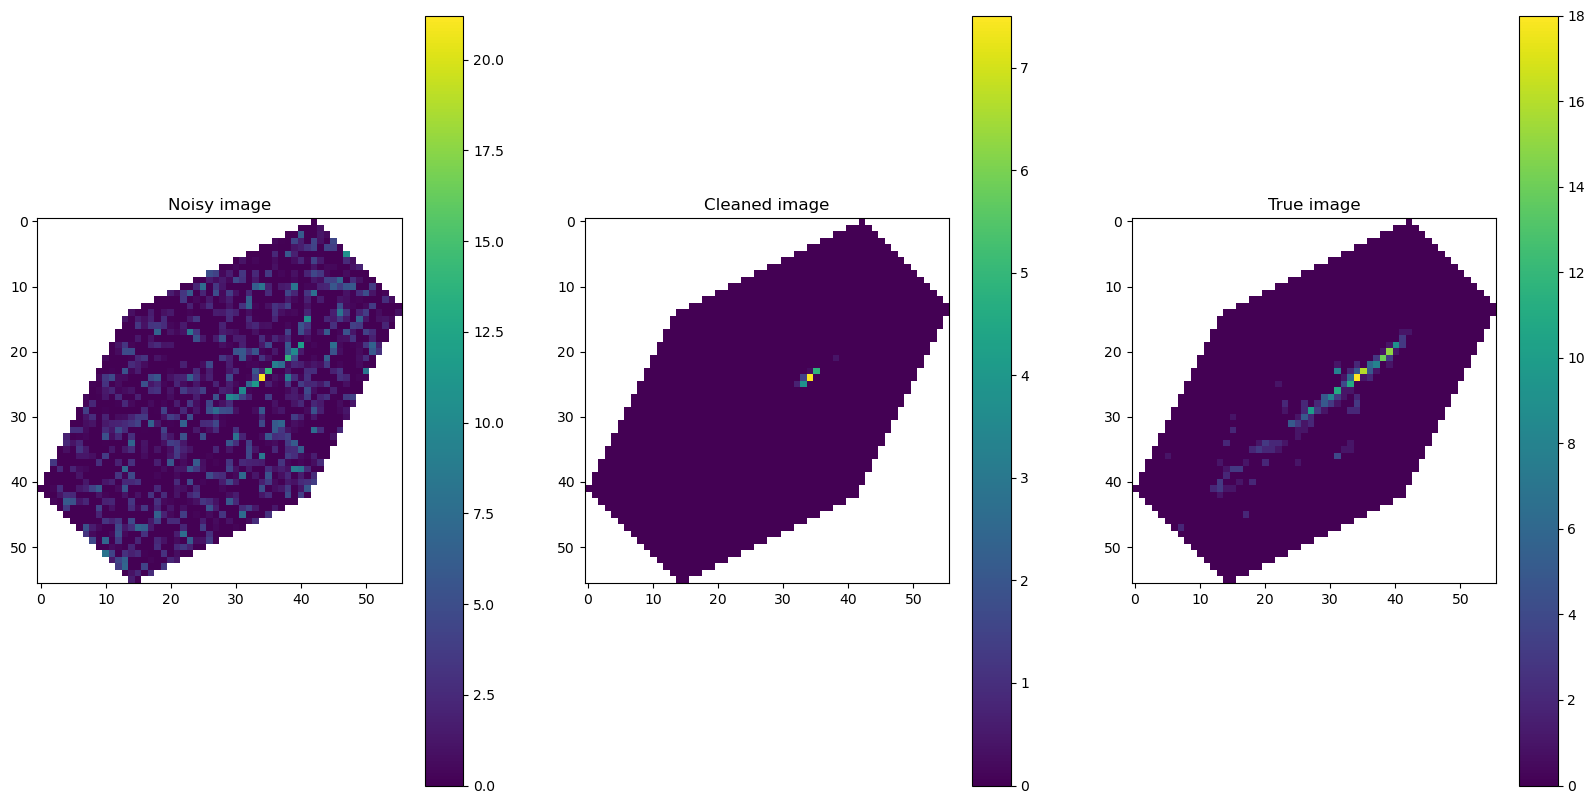

In [21]:
n_start = 3
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))


    im_clean = (output.data).reshape(56, 56)
    
    im_clean = im_clean*(pix_max_noisy[idx_split+im_i][0][0]-pix_min_noisy[idx_split+im_i][0][0]) + pix_min_noisy[idx_split+im_i][0][0]
    print(im_clean.min())
    #im_clean = im_clean_prob.round()
    #mask_clean = im_clean.astype(bool)
    #im_clean_good = np.zeros((56,56))

    #im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,3,figsize=(20,10))

    fig_noisy = axs[0].imshow((data_noisy_test_im[im_i]), vmin=0)
    axs[0].set_title("Noisy image")
    fig.colorbar(fig_noisy, ax=axs[0])

    fig_clean = axs[1].imshow((im_clean.detach().numpy()), vmin=0)
    axs[1].set_title("Cleaned image")
    fig.colorbar(fig_clean, ax=axs[1])

    fig_true = axs[2].imshow((data_true_test_im[im_i]), vmin=0)
    axs[2].set_title("True image")
    fig.colorbar(fig_true, ax=axs[2])

plt.show()    

**3 layers**

In [22]:
%%time

learning_rate = 0.0001

network = AE3()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*100 for i in range(n_epochs + 1)]


test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)



Test set: Avg. loss: 0.012956
Training set: Avg. loss: 0.0005

Test set: Avg. loss: 0.000306
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000252
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000227
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000216
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000200
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000195
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000193
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000187
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000182
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000180
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000183
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000182
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000178
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000173
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000172
Training set: Avg. loss:

tensor(-8.1280)
tensor(-7.3995)
tensor(-8.2124)


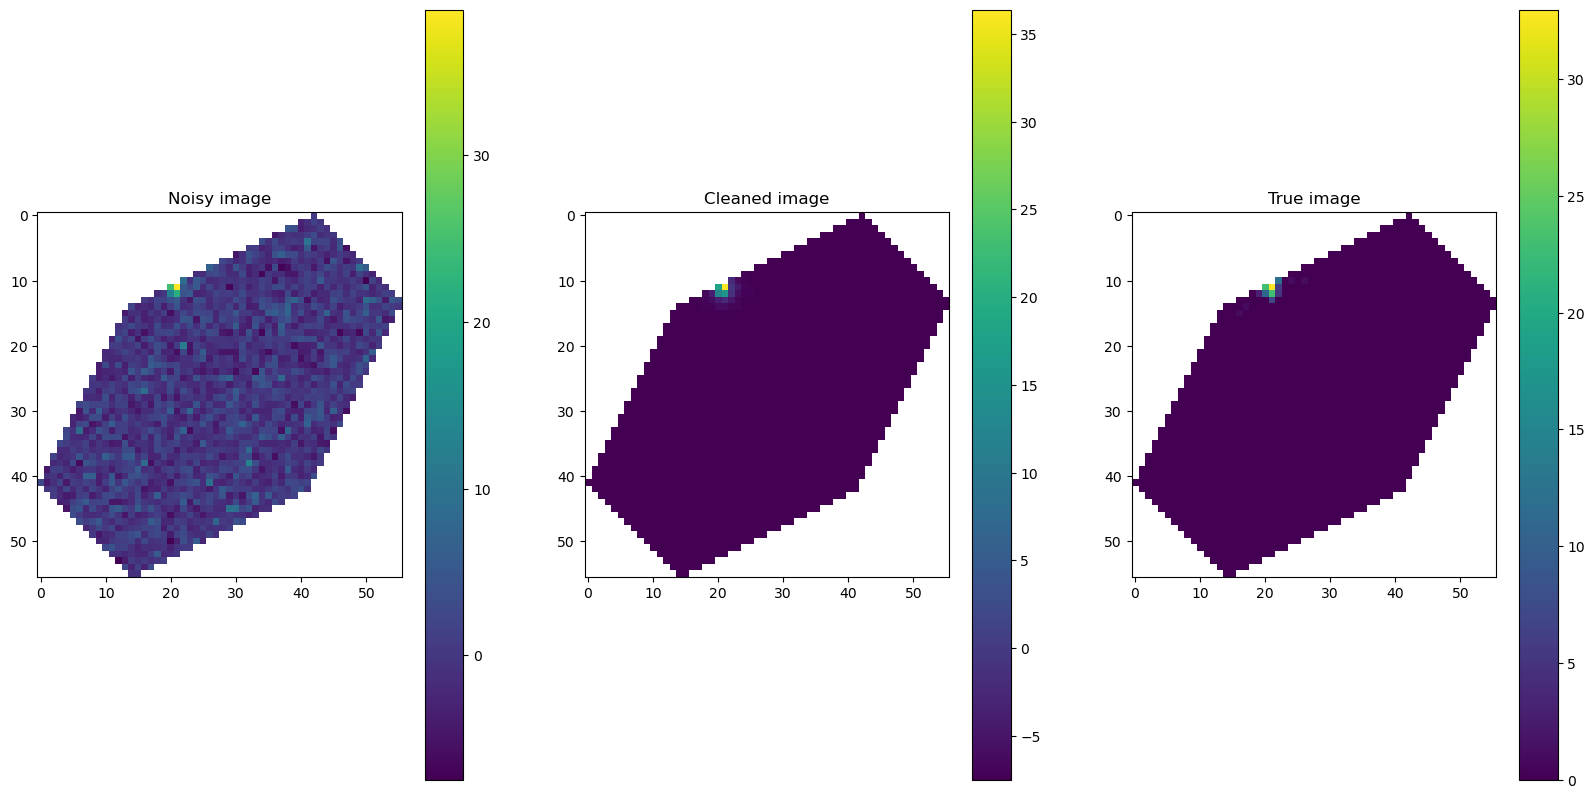

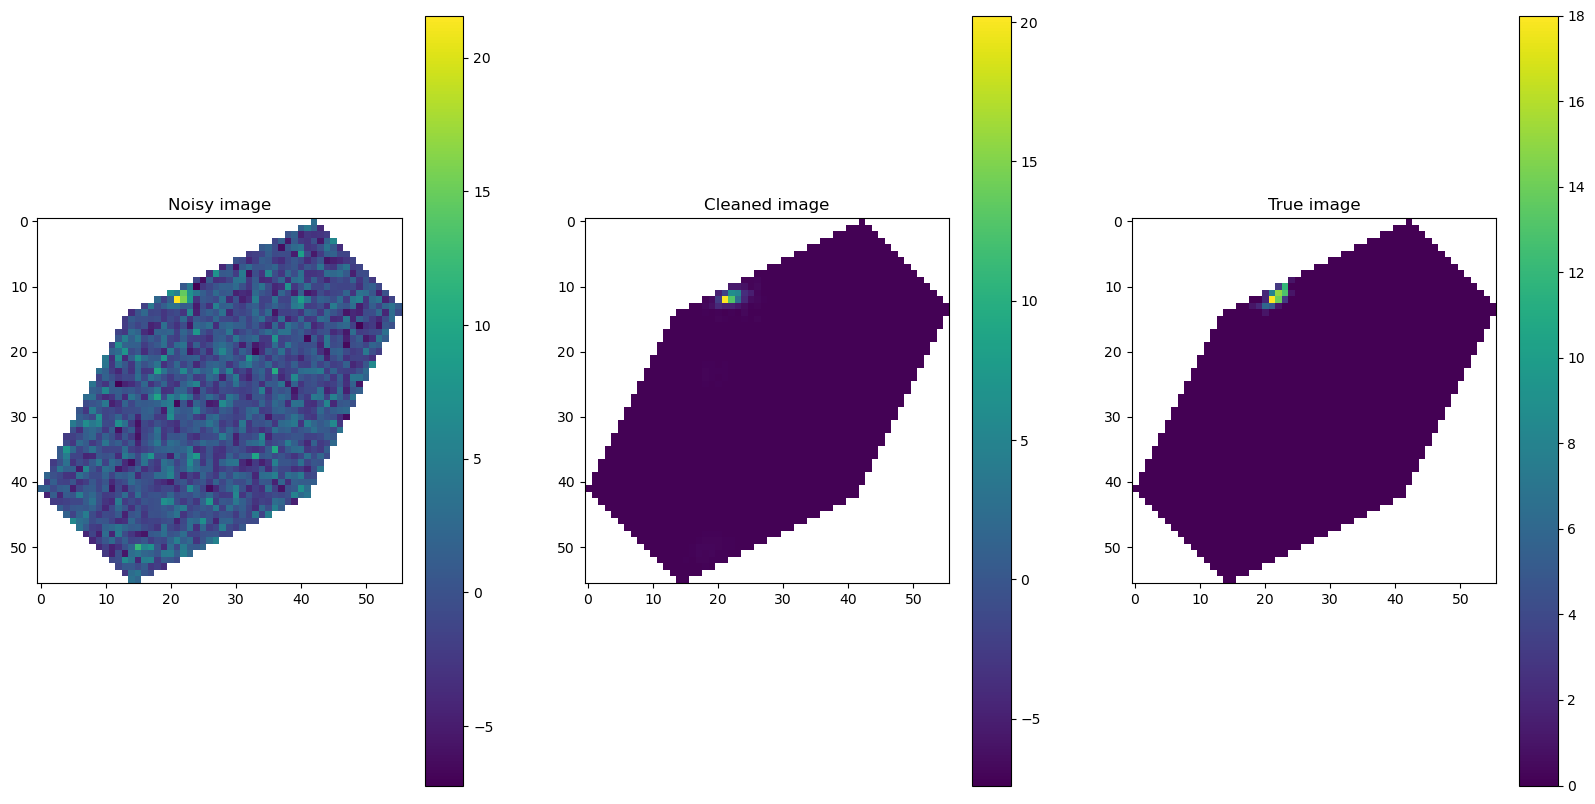

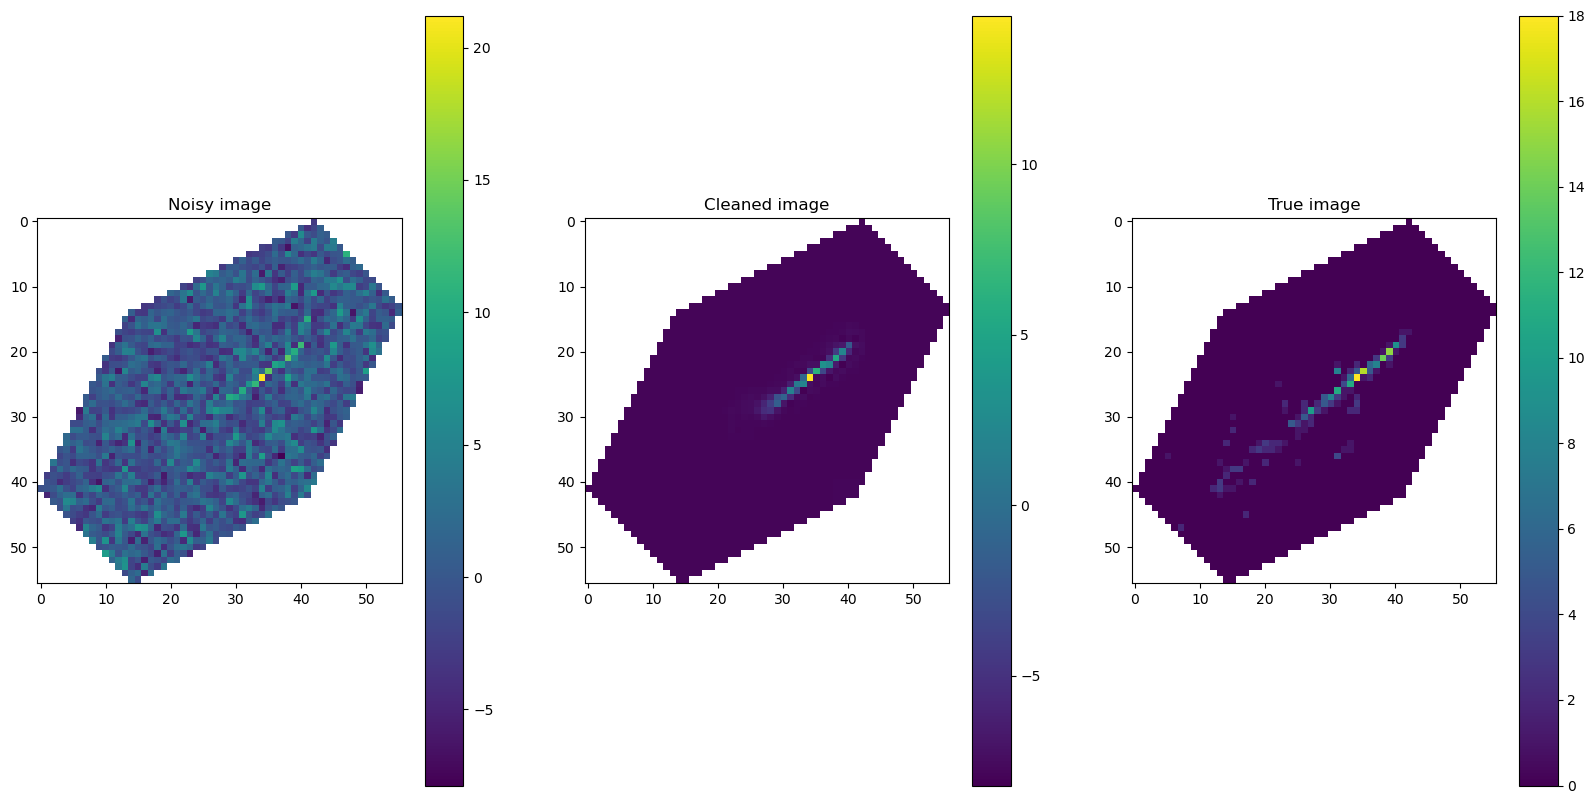

In [24]:
n_start = 3
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))


    im_clean = (output.data).reshape(56, 56)
    
    im_clean = im_clean*(pix_max_noisy[idx_split+im_i][0][0]-pix_min_noisy[idx_split+im_i][0][0]) + pix_min_noisy[idx_split+im_i][0][0]
    print(im_clean.min())
    #im_clean = im_clean_prob.round()
    #mask_clean = im_clean.astype(bool)
    #im_clean_good = np.zeros((56,56))

    #im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,3,figsize=(20,10))

    fig_noisy = axs[0].imshow(data_noisy_test_im[im_i])#, vmin=0)
    axs[0].set_title("Noisy image")
    fig.colorbar(fig_noisy, ax=axs[0])

    fig_clean = axs[1].imshow(im_clean.detach().numpy())#, vmin=0)
    axs[1].set_title("Cleaned image")
    fig.colorbar(fig_clean, ax=axs[1])

    fig_true = axs[2].imshow(data_true_test_im[im_i])#, vmin=0)
    axs[2].set_title("True image")
    fig.colorbar(fig_true, ax=axs[2])

plt.show()    

**4 layers**

In [25]:
%%time

learning_rate = 0.0001

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*100 for i in range(n_epochs + 1)]


test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)



Test set: Avg. loss: 0.024680
Training set: Avg. loss: 0.0006

Test set: Avg. loss: 0.000333
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000267
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000235
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000229
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000220
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000202
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000194
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000187
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000182
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000185
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000179
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000189
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000174
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000173
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000171
Training set: Avg. loss:

tensor(-0.7342)
tensor(-0.1434)
tensor(-0.4231)


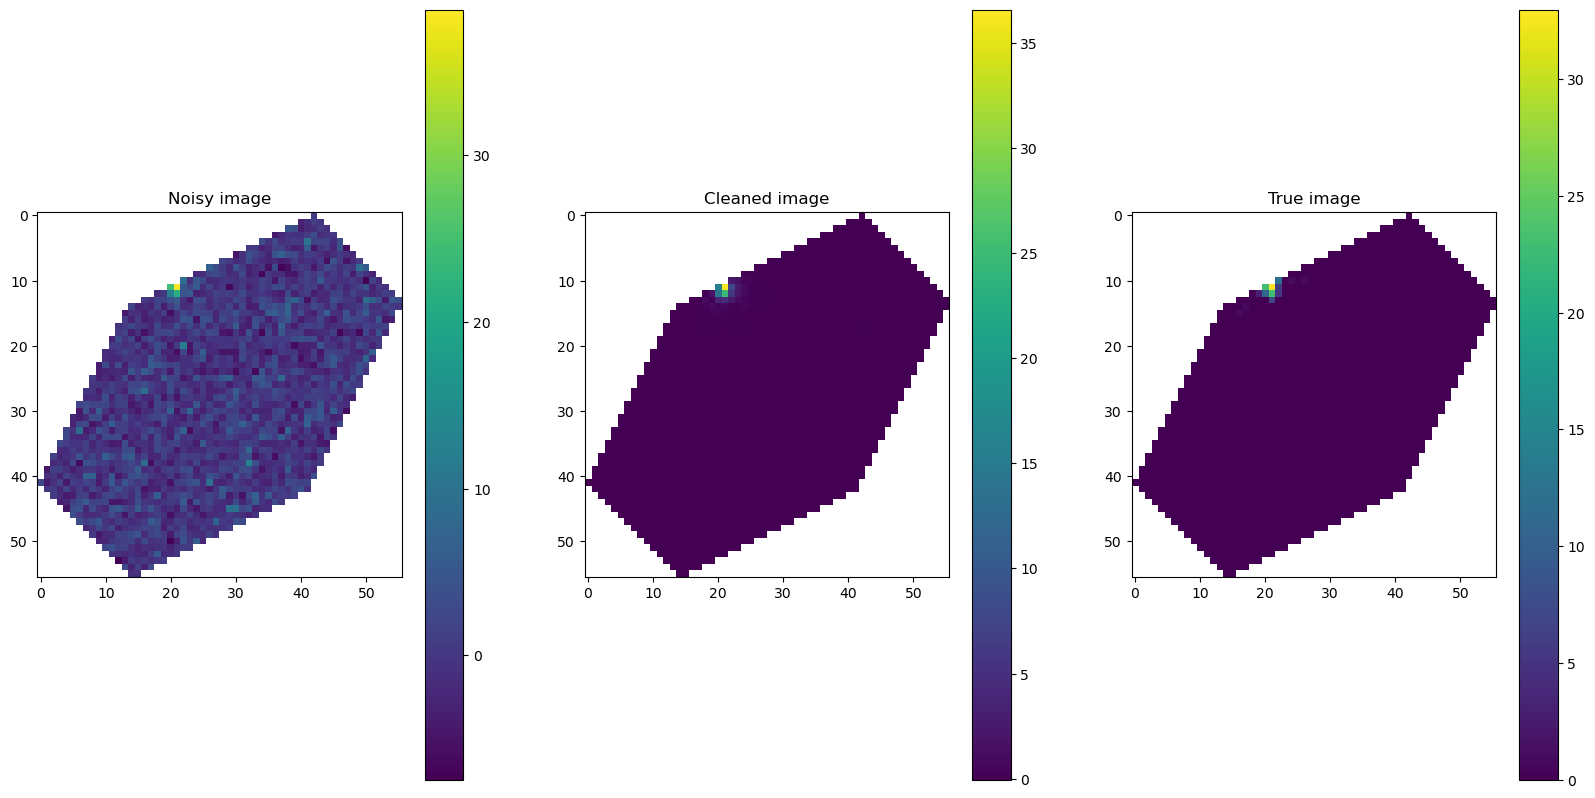

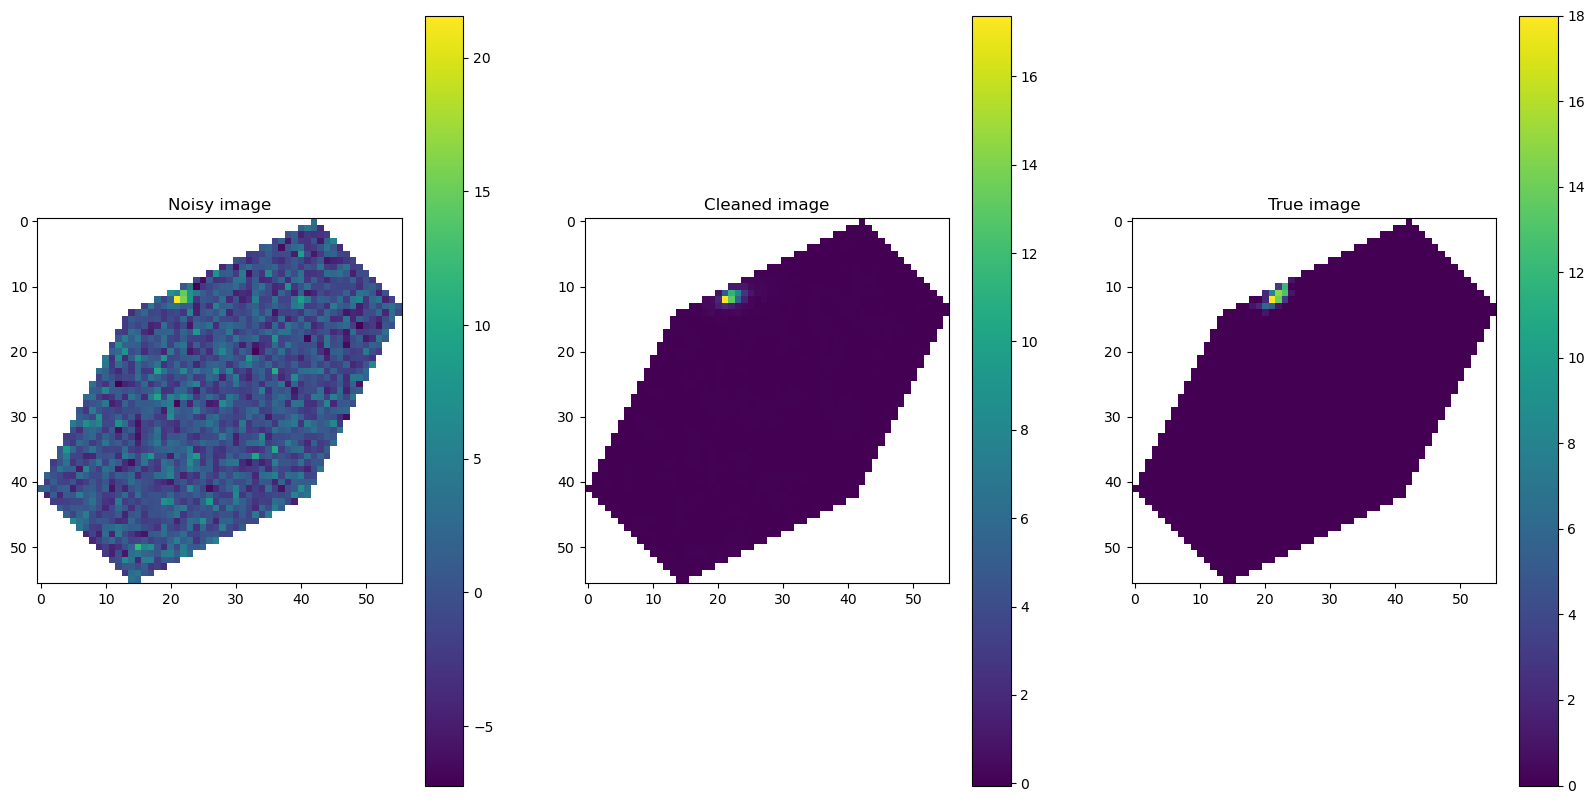

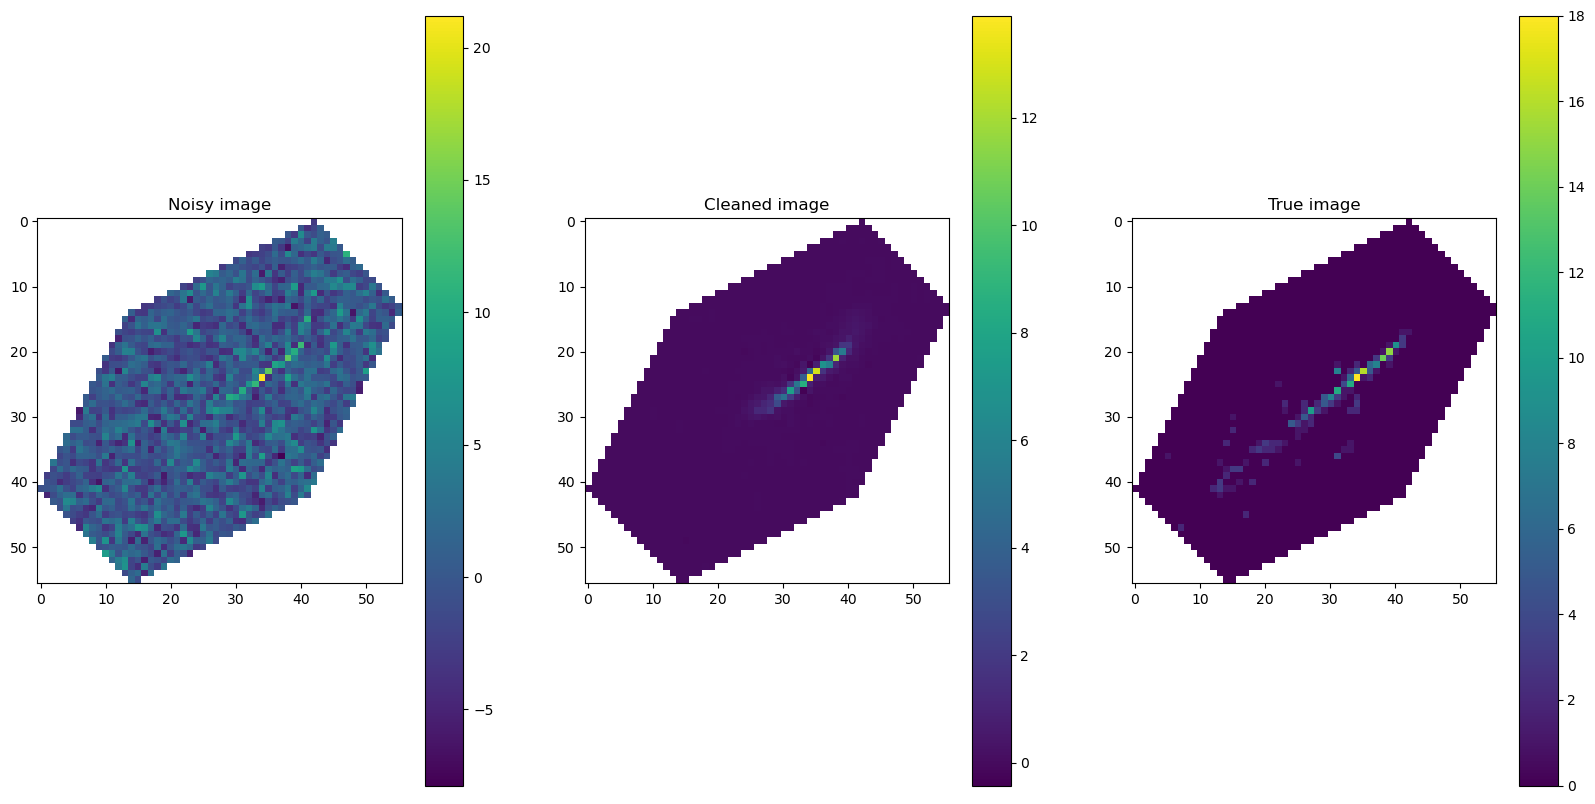

In [26]:
n_start = 3
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))


    im_clean = (output.data).reshape(56, 56)
    
    #im_clean = im_clean*(pix_max_noisy[idx_split+im_i][0][0]-pix_min_noisy[idx_split+im_i][0][0]) + pix_min_noisy[idx_split+im_i][0][0]
    im_clean = im_clean*pix_max_noisy[idx_split+im_i][0][0]
    print(im_clean.min())
    #im_clean = im_clean_prob.round()
    #mask_clean = im_clean.astype(bool)
    #im_clean_good = np.zeros((56,56))

    #im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,3,figsize=(20,10))

    fig_noisy = axs[0].imshow(data_noisy_test_im[im_i])#, vmin=0)
    axs[0].set_title("Noisy image")
    fig.colorbar(fig_noisy, ax=axs[0])

    fig_clean = axs[1].imshow(im_clean.detach().numpy())#, vmin=0)
    axs[1].set_title("Cleaned image")
    fig.colorbar(fig_clean, ax=axs[1])

    fig_true = axs[2].imshow(data_true_test_im[im_i])#, vmin=0)
    axs[2].set_title("True image")
    fig.colorbar(fig_true, ax=axs[2])

plt.show()    

**5 layers**

In [27]:
%%time

learning_rate = 0.0001

network = AE5()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*100 for i in range(n_epochs + 1)]


test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)



Test set: Avg. loss: 0.019400
Training set: Avg. loss: 0.0005

Test set: Avg. loss: 0.000244
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000226
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000278
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000188
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000186
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000174
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000177
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000177
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000168
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000177
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000169
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000167
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000173
Training set: Avg. loss: 0.0001

Test set: Avg. loss: 0.000163
Training set: Avg. loss: 0.0001

Test set: Avg. loss: 0.000160
Training set: Avg. loss:

tensor(-0.1165)
tensor(-0.2316)
tensor(-0.0870)


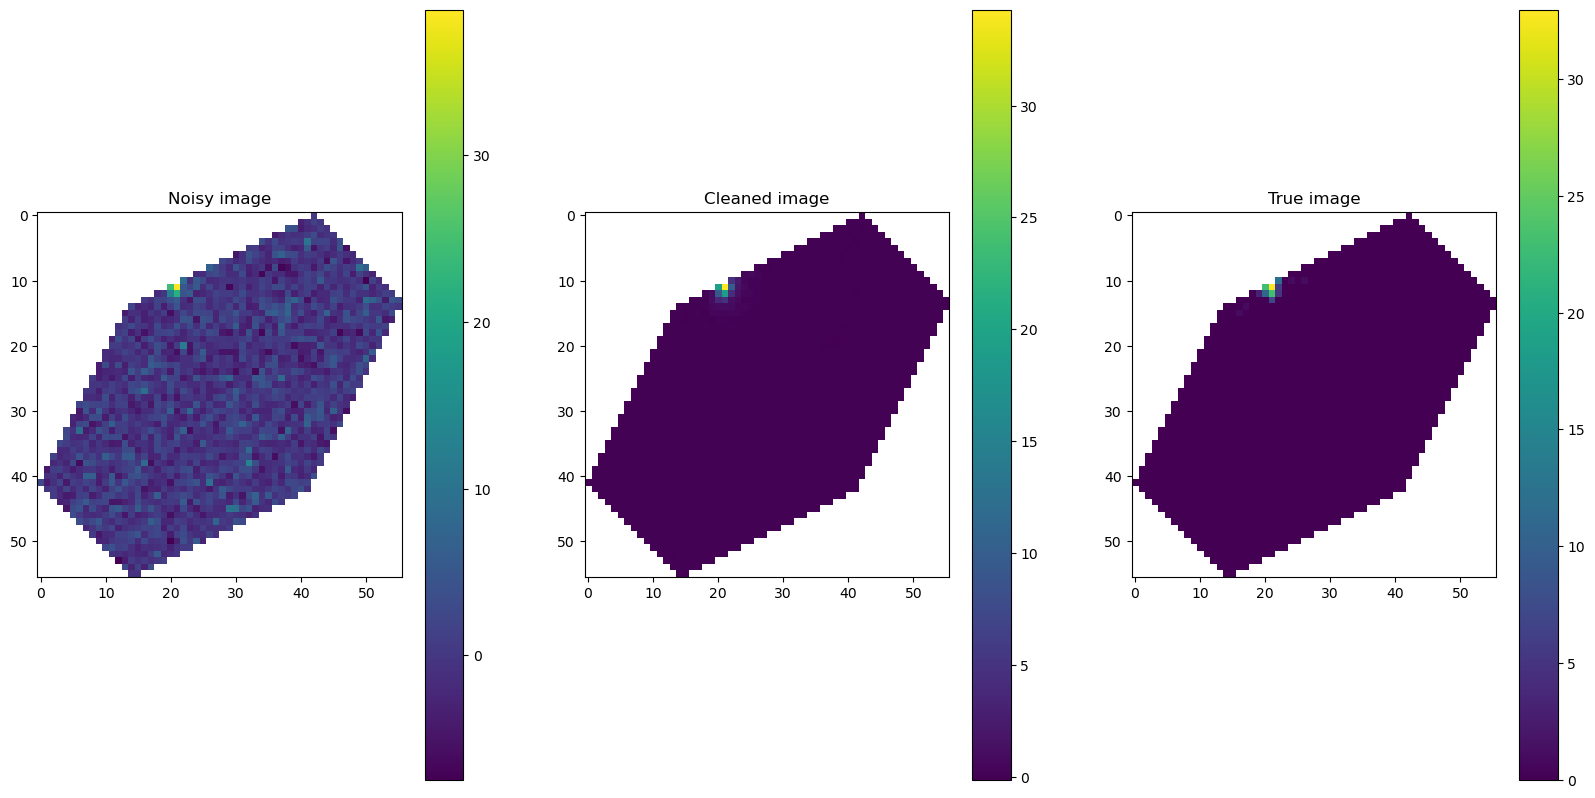

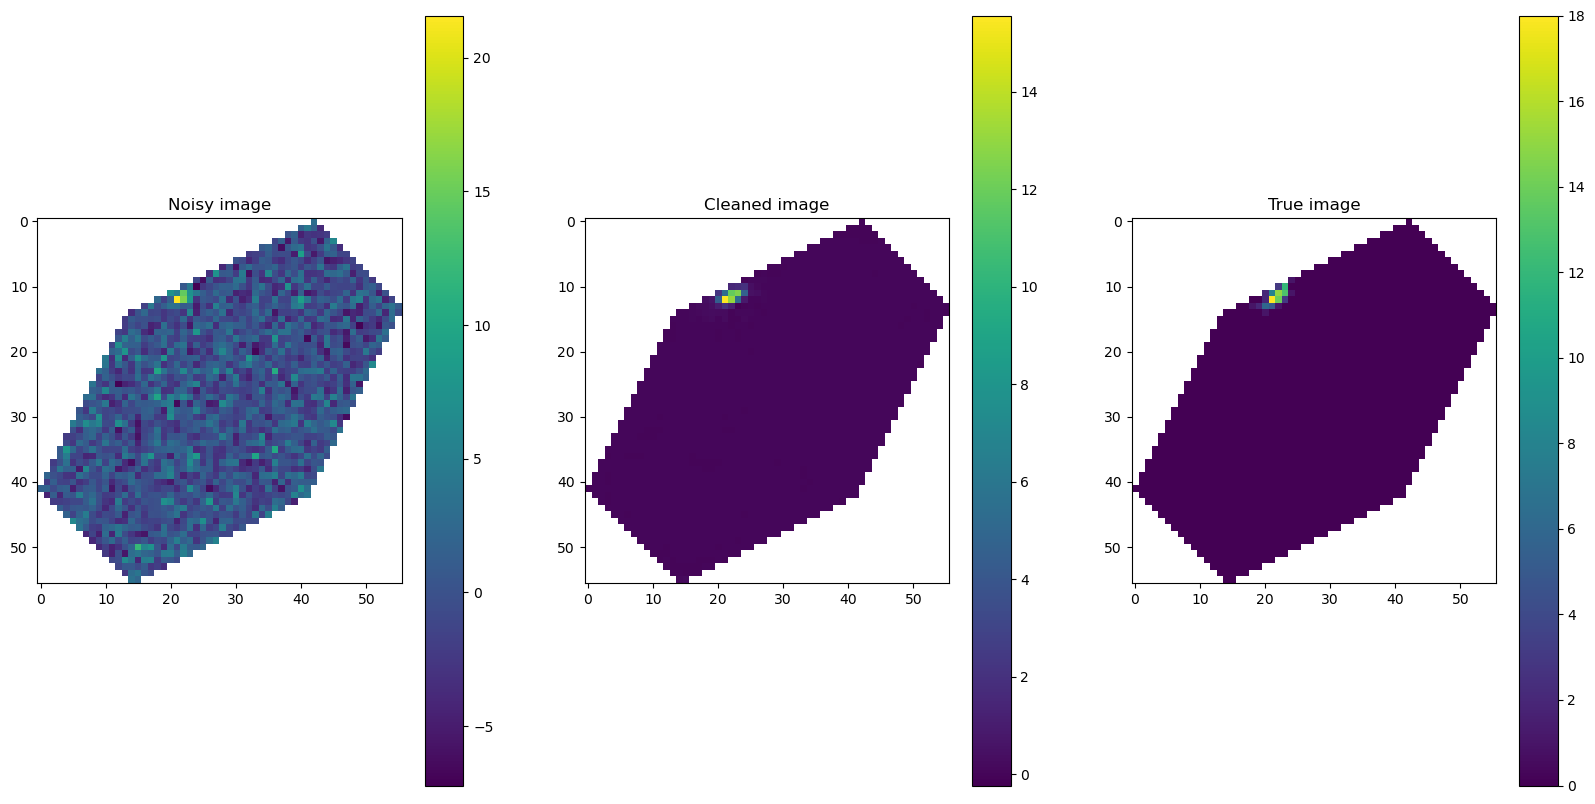

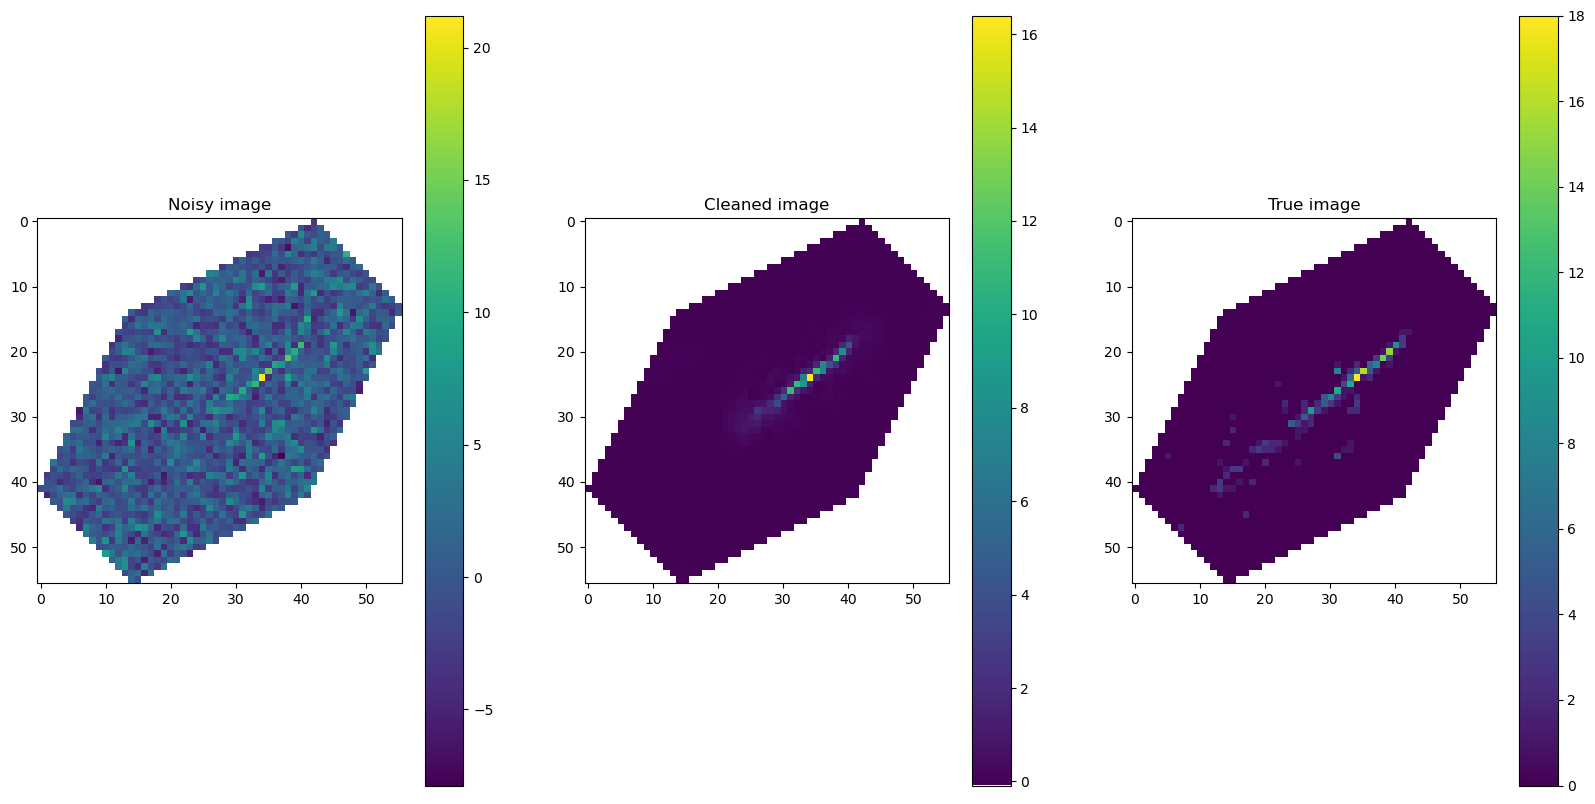

In [28]:
n_start = 3
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))


    im_clean = (output.data).reshape(56, 56)
    
    #im_clean = im_clean*(pix_max_noisy[idx_split+im_i][0][0]-pix_min_noisy[idx_split+im_i][0][0]) + pix_min_noisy[idx_split+im_i][0][0]
    im_clean = im_clean*pix_max_noisy[idx_split+im_i][0][0]
    print(im_clean.min())
    #im_clean = im_clean_prob.round()
    #mask_clean = im_clean.astype(bool)
    #im_clean_good = np.zeros((56,56))

    #im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,3,figsize=(20,10))

    fig_noisy = axs[0].imshow(data_noisy_test_im[im_i])#, vmin=0)
    axs[0].set_title("Noisy image")
    fig.colorbar(fig_noisy, ax=axs[0])

    fig_clean = axs[1].imshow(im_clean.detach().numpy())#, vmin=0)
    axs[1].set_title("Cleaned image")
    fig.colorbar(fig_clean, ax=axs[1])

    fig_true = axs[2].imshow(data_true_test_im[im_i])#, vmin=0)
    axs[2].set_title("True image")
    fig.colorbar(fig_true, ax=axs[2])

plt.show()    

**6 layers**

In [29]:
%%time

learning_rate = 0.0001

network = AE6()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*100 for i in range(n_epochs + 1)]


test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)



Test set: Avg. loss: 0.086183
Training set: Avg. loss: 0.0007

Test set: Avg. loss: 0.000250
Training set: Avg. loss: 0.0003

Test set: Avg. loss: 0.000205
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000191
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000186
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000179
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000190
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000173
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000170
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000175
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000167
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000179
Training set: Avg. loss: 0.0002

Test set: Avg. loss: 0.000172
Training set: Avg. loss: 0.0001

Test set: Avg. loss: 0.000165
Training set: Avg. loss: 0.0001

Test set: Avg. loss: 0.000164
Training set: Avg. loss: 0.0001

Test set: Avg. loss: 0.000165
Training set: Avg. loss:

**Compare**

In [30]:
test_losses_arr = np.array(test_losses_all)

In [32]:
print(test_losses_arr.shape)

(6, 41)


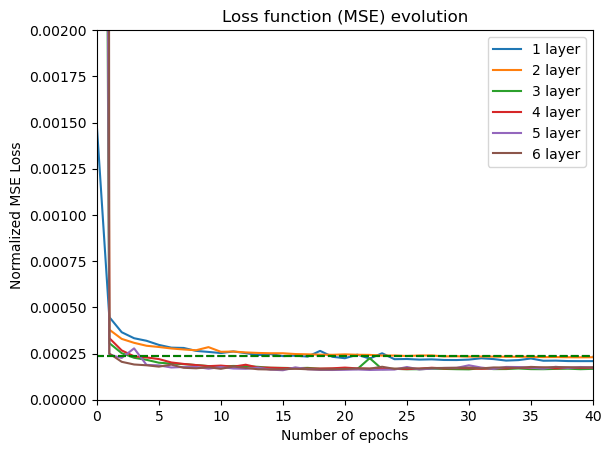

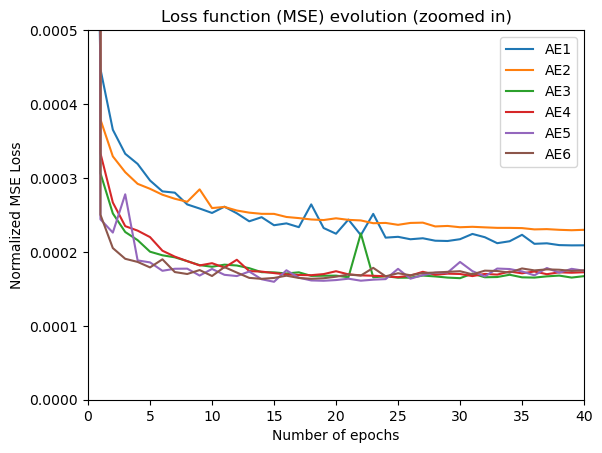

In [34]:
test_counter = np.linspace(0, n_epochs, n_epochs+1)

plt.figure()
plt.title("Loss function (MSE) evolution")
plt.plot(test_counter, test_losses_arr[0], label='1 layer')
plt.plot(test_counter, test_losses_arr[1], label='2 layer')
plt.plot(test_counter, test_losses_arr[2], label='3 layer')
plt.plot(test_counter, test_losses_arr[3], label='4 layer')
plt.plot(test_counter, test_losses_arr[4], label='5 layer')
plt.plot(test_counter, test_losses_arr[5], label='6 layer')
plt.xlabel("Number of epochs")
plt.ylabel("Normalized MSE Loss")
plt.legend()
plt.xlim(0,40)
plt.ylim(0,0.0020)
#plt.hlines(0.000177, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
#plt.hlines(0.000141, -1, n_epochs+1, color='green', linestyles='--', label='Segmentation')
plt.hlines(0.00023664429947151884, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
plt.hlines(0.0002363444978731545, -1, n_epochs+1, color='green', linestyles='--', label='Segmentation')
plt.show()

plt.figure()
plt.title("Loss function (MSE) evolution (zoomed in)")
plt.plot(test_counter, test_losses_arr[0], label='AE1')
plt.plot(test_counter, test_losses_arr[1], label='AE2')
plt.plot(test_counter, test_losses_arr[2], label='AE3')
plt.plot(test_counter, test_losses_arr[3], label='AE4')
plt.plot(test_counter, test_losses_arr[4], label='AE5')
plt.plot(test_counter, test_losses_arr[5], label='AE6')
plt.xlabel("Number of epochs")
plt.ylabel("Normalized MSE Loss")
plt.legend()
plt.xlim(0,40)
plt.ylim(0,0.0005)
plt.show()

In [35]:

test_losses_mean = np.mean(test_losses_arr[:,20:30], axis=1)
test_losses_std = np.std(test_losses_arr[:,20:30], axis=1)


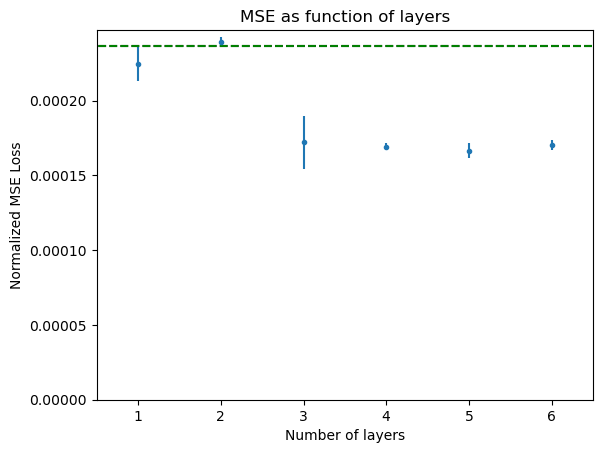

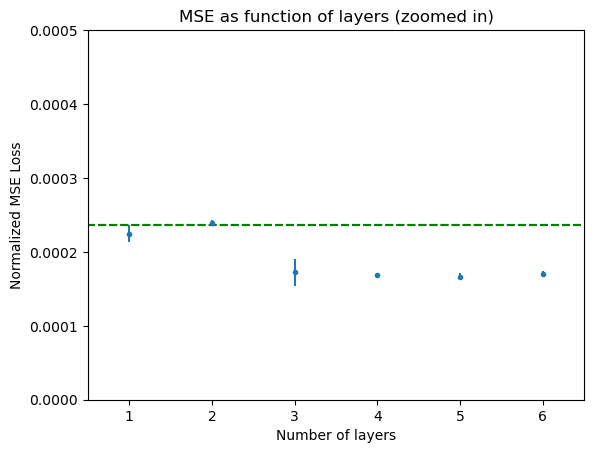

In [37]:
layers = np.array([1,2,3,4,5,6])

plt.figure()
plt.title("MSE as function of layers")
plt.errorbar(layers, test_losses_mean, yerr=test_losses_std, fmt='.')
plt.xlabel("Number of layers")
plt.ylabel("Normalized MSE Loss")
plt.xlim(0.5,6.5)
plt.ylim(0,)
plt.show()

plt.figure()
plt.title("MSE as function of layers (zoomed in)")
plt.errorbar(layers, test_losses_mean, yerr=test_losses_std, fmt='.')
plt.xlabel("Number of layers")
plt.ylabel("Normalized MSE Loss")
plt.xlim(0.5,6.5)
plt.ylim(0,0.0005)
plt.show()

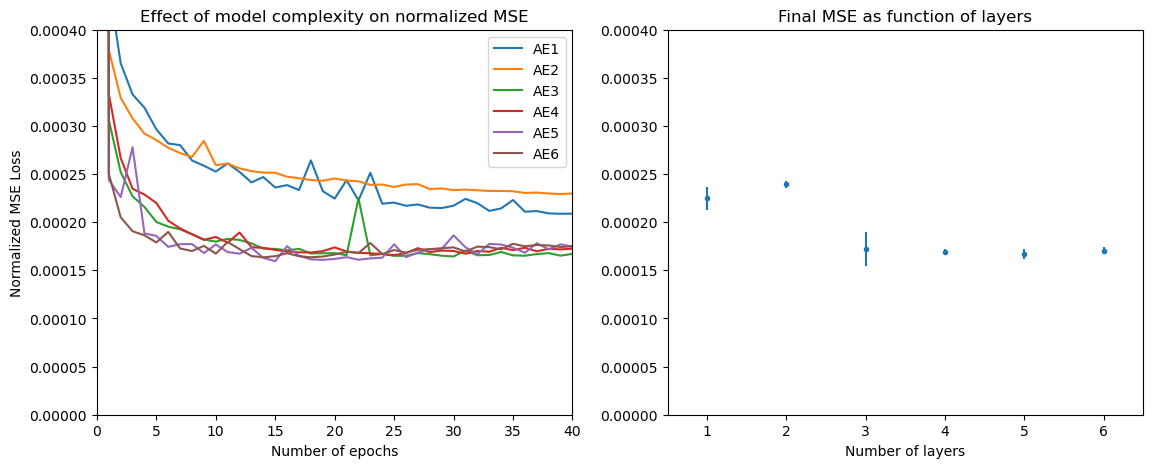

In [45]:
fig_regmodels, axs = plt.subplots(1,2,figsize=(13.5,5))

axs[0].set_title("Effect of model complexity on normalized MSE")
axs[0].plot(test_counter, test_losses_arr[0], label='AE1')
axs[0].plot(test_counter, test_losses_arr[1], label='AE2')
axs[0].plot(test_counter, test_losses_arr[2], label='AE3')
axs[0].plot(test_counter, test_losses_arr[3], label='AE4')
axs[0].plot(test_counter, test_losses_arr[4], label='AE5')
axs[0].plot(test_counter, test_losses_arr[5], label='AE6')
axs[0].set_xlabel("Number of epochs")
axs[0].set_ylabel("Normalized MSE Loss")
axs[0].legend()
axs[0].set_xlim(0,40)
axs[0].set_ylim(0,0.0004)

axs[1].set_title("Final MSE as function of layers")
axs[1].errorbar(layers, test_losses_mean, yerr=test_losses_std, fmt='.')
axs[1].set_xlabel("Number of layers")
#axs[1].set_ylabel("Normalized MSE Loss")
axs[1].set_xlim(0.5,6.5)
axs[1].set_ylim(0,0.0004)

plt.show()
fig_regmodels.savefig("images/ModelsRegression.pdf")

**Some examples**

tensor(-7.7693)
tensor(-7.4424)
tensor(-8.2769)


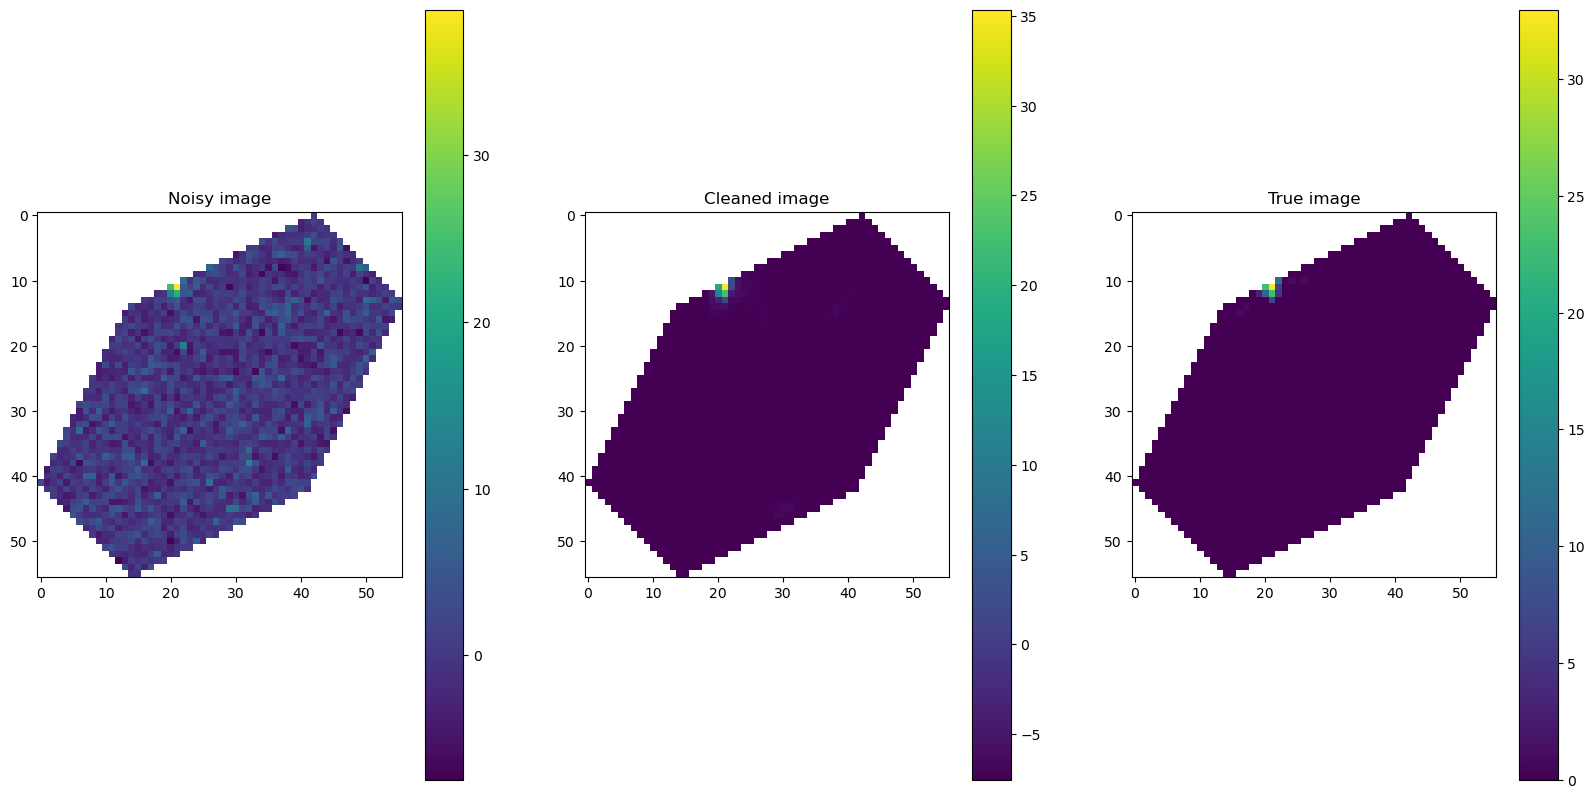

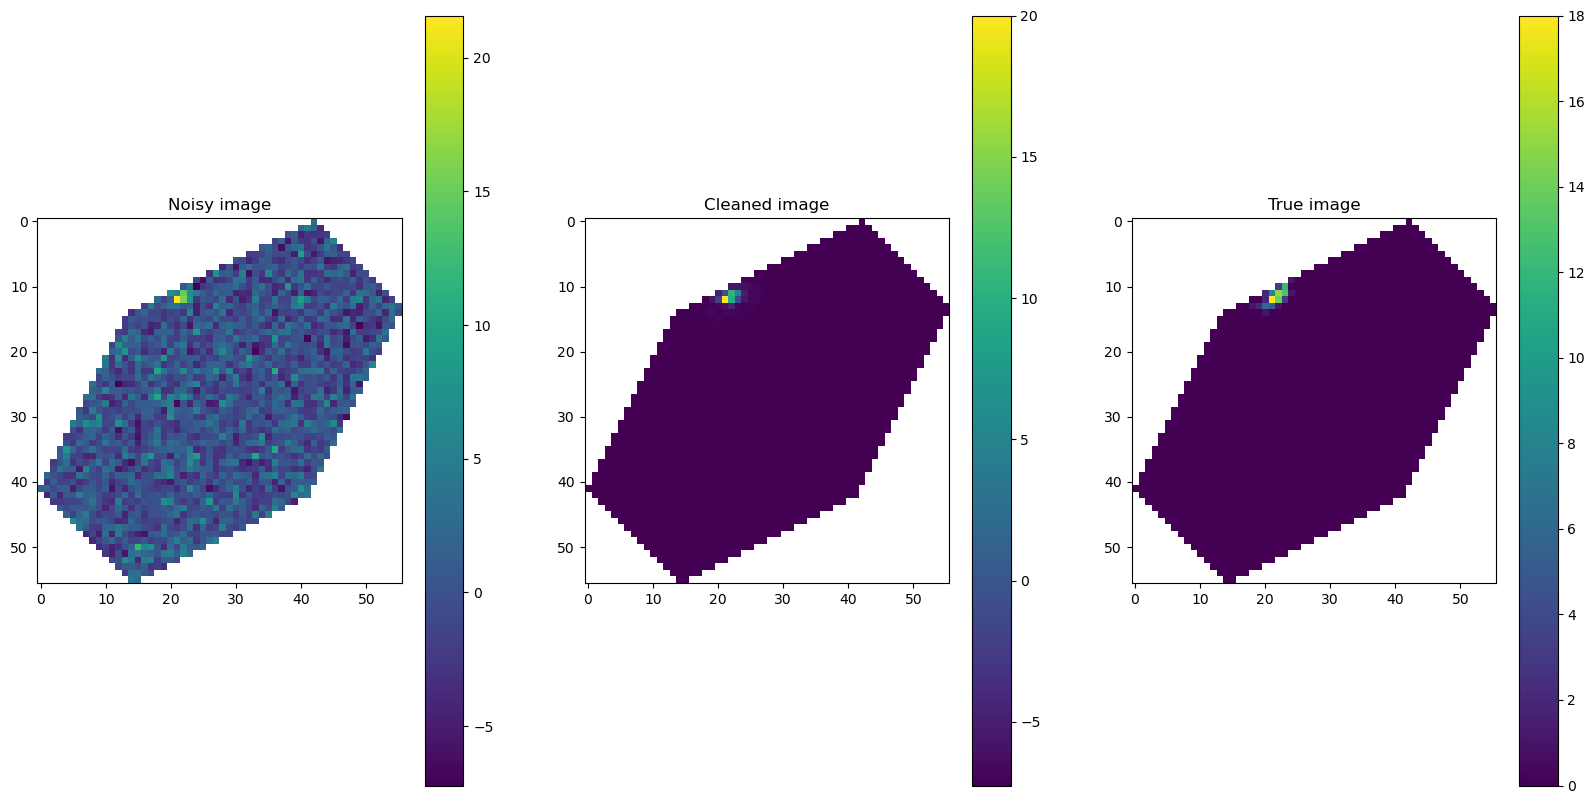

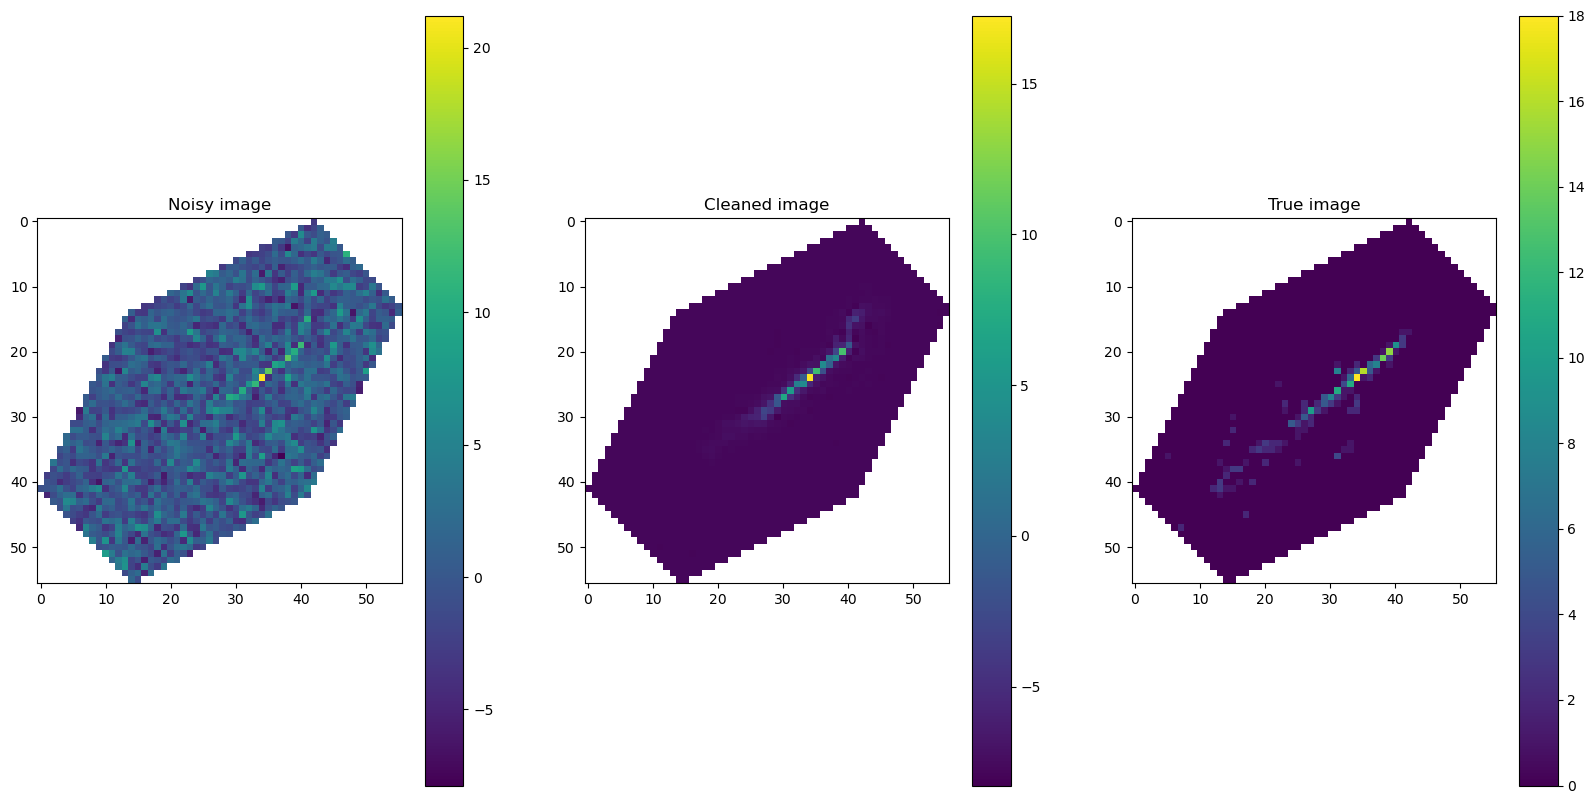

In [167]:
n_start = 3
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))


    im_clean = (output.data).reshape(56, 56)
    
    im_clean = im_clean*(pix_max_noisy[idx_split+im_i][0][0]-pix_min_noisy[idx_split+im_i][0][0]) + pix_min_noisy[idx_split+im_i][0][0]
    print(im_clean.min())
    #im_clean = im_clean_prob.round()
    #mask_clean = im_clean.astype(bool)
    #im_clean_good = np.zeros((56,56))

    #im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,3,figsize=(20,10))

    fig_noisy = axs[0].imshow(data_noisy_test_im[im_i])#, vmin=0)
    axs[0].set_title("Noisy image")
    fig.colorbar(fig_noisy, ax=axs[0])

    fig_clean = axs[1].imshow(im_clean.detach().numpy())#, vmin=0)
    axs[1].set_title("Cleaned image")
    fig.colorbar(fig_clean, ax=axs[1])

    fig_true = axs[2].imshow(data_true_test_im[im_i])#, vmin=0)
    axs[2].set_title("True image")
    fig.colorbar(fig_true, ax=axs[2])

plt.show()    